In [1]:
import os

if 'google.colab' in str(get_ipython()):
    if not os.path.exists('/content/comp551-assignment-2'):
        !git clone https://github.com/johnnyd212/comp551-assignment-2.git
    %cd /content/comp551-assignment-2/notebooks

/content/comp551-assignment-2/notebooks


In [2]:
import numpy as np
import pandas as pd

## Loading the data

Our CSV file is unlabeled, so we create our column names following the description in spambase.DOCUMENTATION:

In [3]:
word_freq_names = [f'word_freq_{i}' for i in range(1, 49)]
char_freq_names = [f'char_freq_{i}' for i in range(1, 7)]
cap_run_attr = ['average', 'longest', 'total']

col_names = (
    word_freq_names +
    char_freq_names +
    ['capital_run_length_' + s for s in cap_run_attr] +
    ['spam']
)

In [4]:
df = pd.read_csv('../data/spambase.data', header=None, names=col_names)
df.head()

,word_freq_1,word_freq_2,word_freq_3,word_freq_4,word_freq_5,word_freq_6,word_freq_7,word_freq_8,word_freq_9,word_freq_10,...,char_freq_1,char_freq_2,char_freq_3,char_freq_4,char_freq_5,char_freq_6,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


#**Part 4: L1 - Regularized Logistic Regression and the Regularization Path (Using scikit-learn)**

In [5]:
# Reproducibility
RANDOM_SEED = 2026
rng = np.random.default_rng(RANDOM_SEED)

In [6]:
# Dataset
X = df.drop(columns='spam') # All 57 input features
y = df['spam'] # Target label (spam / not spam)

In [7]:
# Train / Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=RANDOM_SEED, stratify=y)

In [8]:
# Standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (230, 57)
X_test shape: (4371, 57)


###Regularization Path

In [9]:
# Regularizatin grid
Cs = np.logspace(-4, 4, 30) # Recommended Path Construction
print(Cs)

[1.00000000e-04 1.88739182e-04 3.56224789e-04 6.72335754e-04
 1.26896100e-03 2.39502662e-03 4.52035366e-03 8.53167852e-03
 1.61026203e-02 3.03919538e-02 5.73615251e-02 1.08263673e-01
 2.04335972e-01 3.85662042e-01 7.27895384e-01 1.37382380e+00
 2.59294380e+00 4.89390092e+00 9.23670857e+00 1.74332882e+01
 3.29034456e+01 6.21016942e+01 1.17210230e+02 2.21221629e+02
 4.17531894e+02 7.88046282e+02 1.48735211e+03 2.80721620e+03
 5.29831691e+03 1.00000000e+04]


In [10]:
# Regularization path L1

from sklearn.linear_model import LogisticRegression

coefs = [] # Full coefficient vector of each value of C stored in this list
non_zero_coefs = [] # Number of non-zero coefficients to measure the sparsity of the model

model = LogisticRegression(
    penalty="l1",
    solver="saga",
    warm_start=True,
    max_iter=5000,
    tol=1e-4,
    fit_intercept=True,
    random_state=RANDOM_SEED
)

# Looping over regularization strengths
# Using the same model object, while changing C at each iteration
for C in Cs:
    model.set_params(C=C)
    model.fit(X_train, y_train)
    w = model.coef_.ravel()
    coefs.append(w.copy())
    non_zero_coefs.append(np.sum(np.abs(w) > 1e-8))

# Convert lists to arrays
coefs = np.vstack(coefs) # Each row corresponds to one regularization strength
non_zero_coefs = np.array(non_zero_coefs)


###Plot 1. Regularization path of coefficients

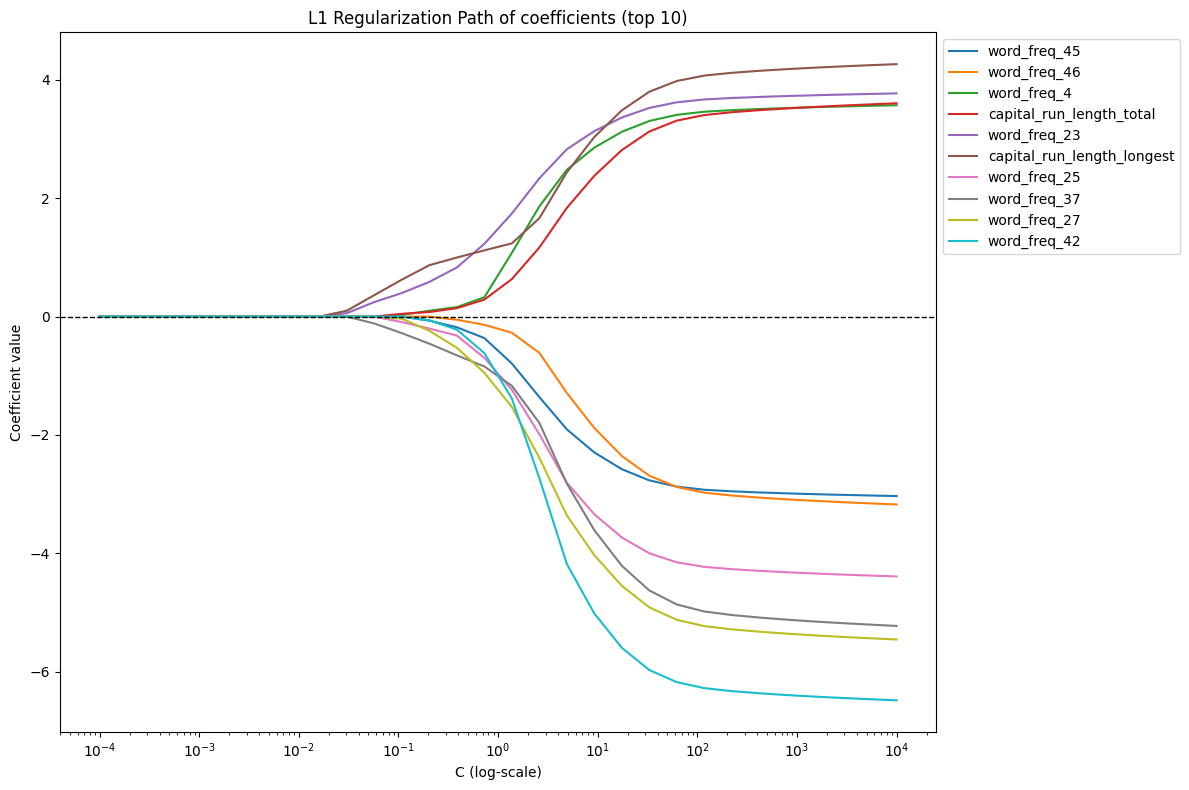

In [11]:
import matplotlib.pyplot as plt

# Only plot the top-k coefficients to keep the plot readable
k = 10
max_abs = np.max(np.abs(coefs), axis=0)
topk_idx = np.argsort(max_abs)[-k:] # 10 strongest features

# Plot Regularization path L1
plt.figure(figsize=(12, 8))
for j in topk_idx:
    plt.plot(Cs, coefs[:, j], label=X_train.columns[j])
plt.xscale("log")
plt.xlabel("C (log-scale)")
plt.ylabel("Coefficient value")
plt.title(f"L1 Regularization Path of coefficients (top {k})")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

###Plot 2. Sparsity plot

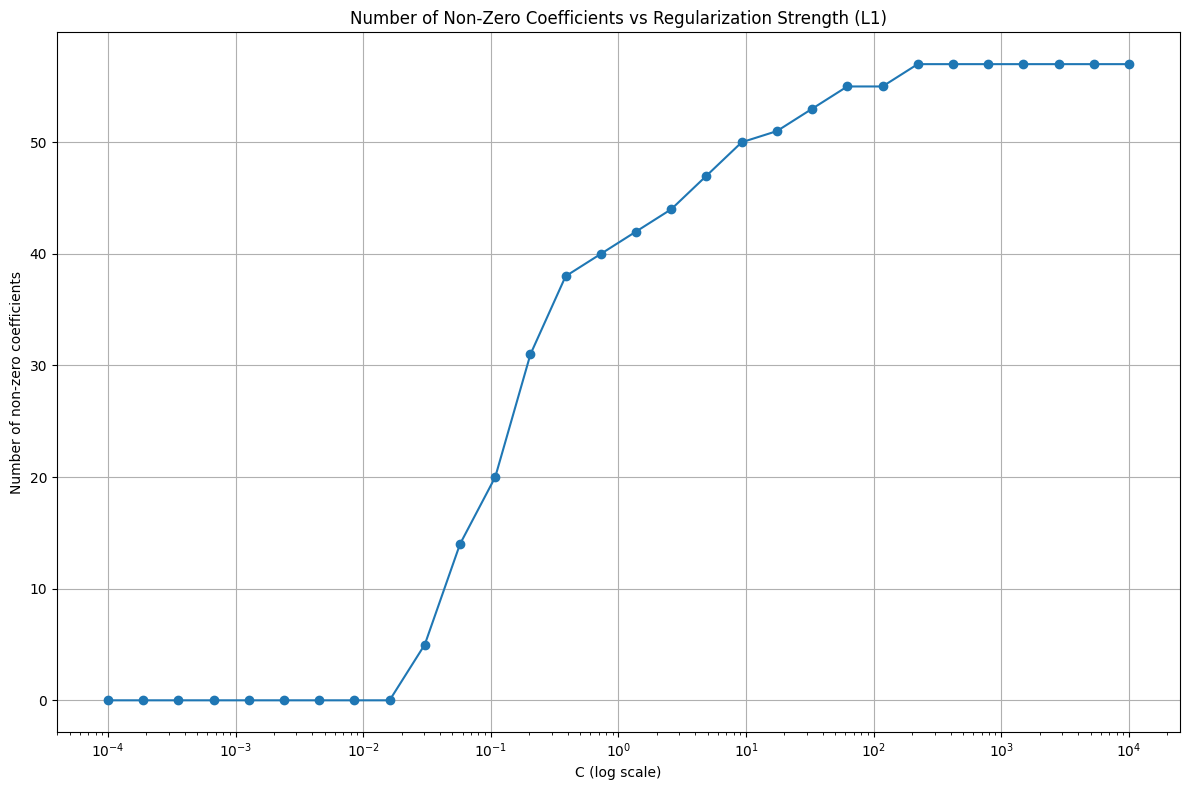

In [12]:
plt.figure(figsize=(12,8))
plt.plot(Cs, non_zero_coefs, marker="o")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Number of non-zero coefficients")
plt.title("Number of Non-Zero Coefficients vs Regularization Strength (L1)")
plt.grid(True)
plt.tight_layout()
plt.show()

###Plot 3. CV accuracy vs C

In [13]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Logistic Regression with built-in cross-validation
lrcv = LogisticRegressionCV(
    Cs=Cs,
    cv=cv,
    penalty="l1",
    solver="saga",
    scoring="accuracy",
    max_iter=5000,
    tol=1e-4,
    fit_intercept=True,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

# Fit the model on training data
lrcv.fit(X_train, y_train)

class_label = list(lrcv.scores_.keys())[0]
cv_scores = lrcv.scores_[class_label]
mean_cv_acc = cv_scores.mean(axis=0)

# Best C selected by cross-validation
best_C = float(lrcv.C_[0])


In [14]:
# Best hyperparameters
print(f"Best C = {best_C:.4f}")
print(f"λ = 1/C = {1/best_C:.4f}")

Best C = 0.7279
λ = 1/C = 1.3738


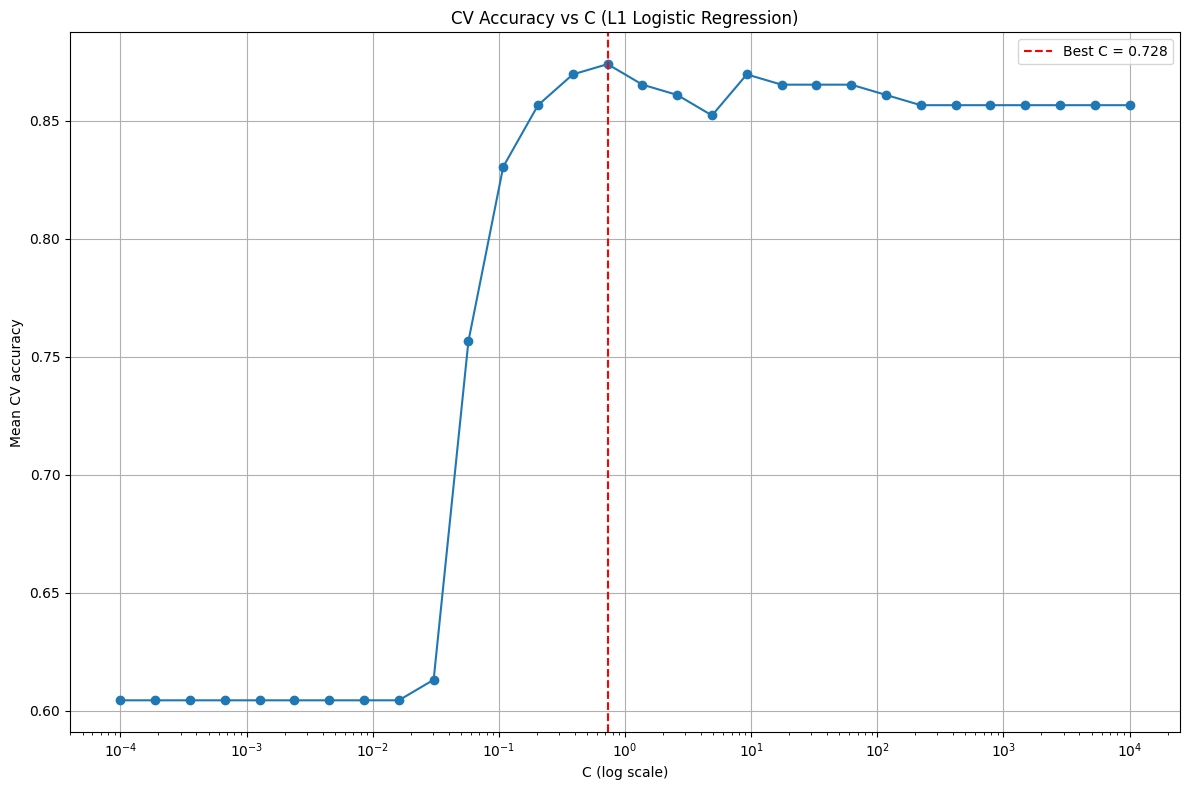

In [15]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(Cs, mean_cv_acc, marker="o")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Mean CV accuracy")
plt.title("CV Accuracy vs C (L1 Logistic Regression)")
plt.axvline(best_C, linestyle="--", color='red', label=f'Best C = {best_C:.3f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()